In [59]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 100, 3.175e-3
delta_r = wavelength / 500

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field
        
#structure_type = 'yagi-uda'
#pos = np.array([[0.0, 0.0, 0.0]])
#angle = np.array([[0.0, 0.0]])
#lengths = np.array([wavelength/2])
#source_position = np.array([[0.0, 0.0, -wavelength/4, incident_field]])
#radii = np.array([radius])
#test = yagi(pos, angle, lengths, source_position, radii)

basis_functions = 'triangle'
structure_type = 'tree'
length = wavelength/4
f = 1/np.sqrt(2)
radius = 3.175e-3
field = incident_field
its = int(np.log(30*delta_r/length) / np.log(f)) - 1
phi = np.full(2 * (2**its - 1), np.pi/6)
test = tree(its,phi,length,f,radius,field)

(np.float64(-0.049447032651000186),
 np.float64(1.0775096956627952),
 np.float64(-0.9016410530855447),
 np.float64(0.9057477990855447))

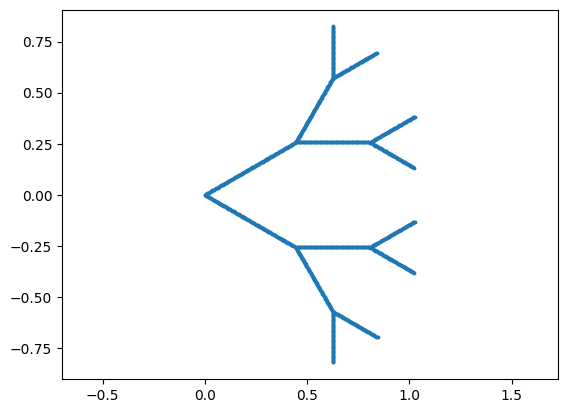

In [60]:
import geometry as gm
import matplotlib.pyplot as plt 
segments_block, _ = gm.tree_to_segments(test, basis_functions, delta_r)
R = [segment.position for block in segments_block for segment in block]
R = np.array(R)
plt.scatter(R[:,0], R[:,1], s = 3)
plt.axis('equal')

In [ ]:
I, R = solve.calc_current_amplitudes(structure_type, basis_functions, test, frequency, delta_r)
np.savez('frac_graph.npz', I=I, R=R)

(np.float64(-0.6753942851298823),
 np.float64(1.0824712265518939),
 np.float64(-1.1901536953627003),
 np.float64(1.1672778228286511))

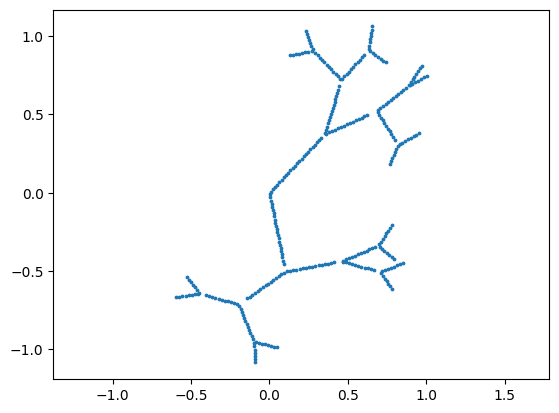

In [46]:

phi = np.random.uniform(0, np.pi/2, 2 * (2**its - 1))
test = tree(its,phi,length,f,radius,field)
import geometry as gm
import matplotlib.pyplot as plt 
segments_block, _ = gm.tree_to_segments(test, basis_functions, delta_r)
R = [segment.position for block in segments_block for segment in block]
R = np.array(R)
plt.scatter(R[:,0], R[:,1], s = 3)
plt.axis('equal')

In [6]:
I, R = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions=basis_functions, antenna=test,frequency=frequency,delta_r=delta_r)

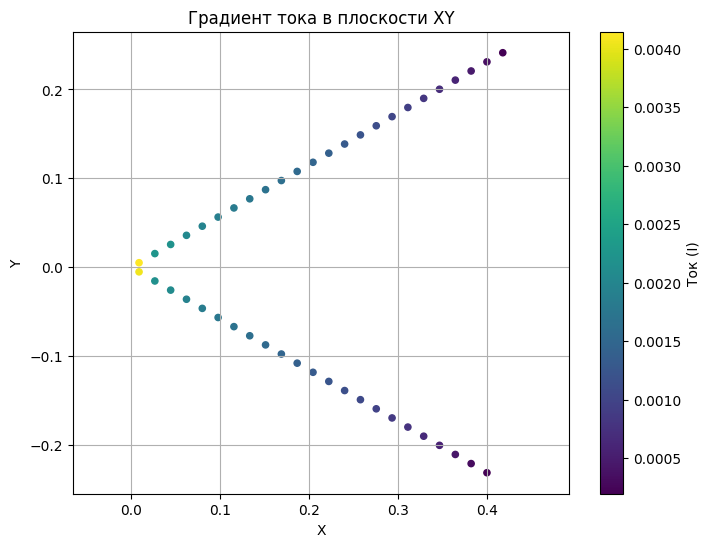

In [7]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8,6))
sc = plt.scatter(R[:,0], R[:,1], c=np.abs(I), cmap='viridis', s=20, marker='o')
plt.colorbar(sc, label='Ток (I)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Градиент тока в плоскости XY')
plt.axis('equal')
plt.grid(True)
plt.show()


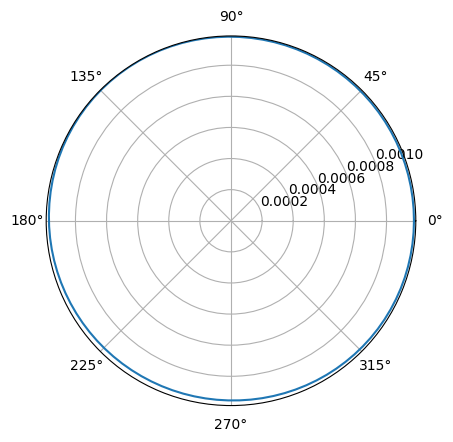

In [10]:
E, angles = solve.calc_field_pattern(phi=0, theta=0, basis_functions=basis_functions, structure_type=structure_type, antenna=test, current=I, R=R, delta_r=delta_r, frequency=frequency)
import matplotlib.pyplot as plt 
plt.polar(angles, E)

In [9]:
from tqdm import tqdm
import time

dr = wavelength / np.linspace(50, 1000, 10)
I_pulse, I_triangle, E_pulse, E_triangle = np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object)
R_pulse, R_triangle = np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object)

time_cur_pulse, time_cur_triangle = [], []
time_e_pulse, time_e_triangle = [], []

for i in tqdm(range(len(dr))) :
    
    start = time.time()
    I_pulse[i], R_pulse[i] = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions='pulse', antenna=test, frequency=frequency, delta_r=dr[i])
    time_cur_pulse.append(time.time() - start)
    
    start = time.time()
    E_pulse[i], angles = solve.calc_field_pattern(phi=0, theta=0, basis_functions='pulse', structure_type=structure_type, antenna = test, current=I_pulse[i], R=R_pulse[i], delta_r=dr[i], frequency=frequency)
    time_e_pulse.append(time.time() - start)
    
    start = time.time()
    I_triangle[i], R_triangle[i] = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions='triangle', antenna=test, frequency=frequency, delta_r=dr[i])
    time_cur_triangle.append(time.time() - start)
    
    start = time.time()
    E_triangle[i], angles = solve.calc_field_pattern(phi=0, theta=0, basis_functions='triangle', structure_type= structure_type, antenna = test, current=I_triangle[i], R=R_triangle[i], delta_r=dr[i], frequency=frequency)
    time_e_triangle.append(time.time() - start)
    
time_cur_pulse, time_cur_triangle = np.array(time_cur_pulse), np.array(time_cur_triangle)
time_e_pulse, time_e_triangle = np.array(time_e_pulse), np.array(time_e_triangle)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 10/10 [35:32<00:00, 213.25s/it]


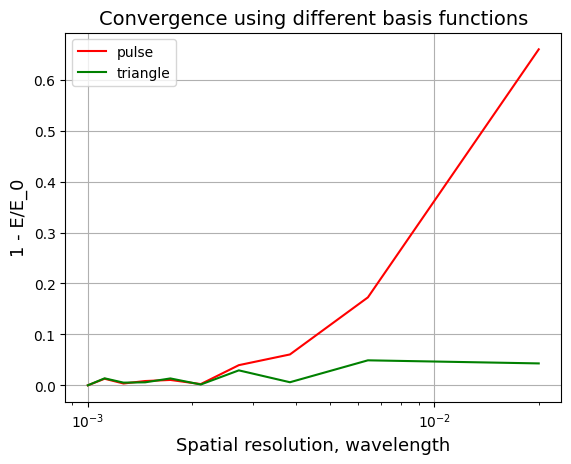

In [18]:
import matplotlib.pyplot as plt
E_max_pulse, E_max_triangle = np.zeros(len(E_pulse)), np.zeros(len(E_pulse))
for i in range(len(E_pulse)):
    E_max_pulse[i] = np.abs(1 - np.max(E_pulse[i])/np.max(E_pulse[-1]))
    E_max_triangle[i] = np.abs(1 - np.max(E_triangle[i])/np.max(E_triangle[-1]))
plt.plot(dr / wavelength, E_max_pulse, color = 'red', label = 'pulse')
plt.plot(dr / wavelength, E_max_triangle, color = 'green', label = 'triangle')
plt.xlabel("Spatial resolution, wavelength", size = 13)
plt.ylabel("1 - E/E_0", size = 13)
plt.title("Convergence using different basis functions", size = 14)
plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
plt.legend()

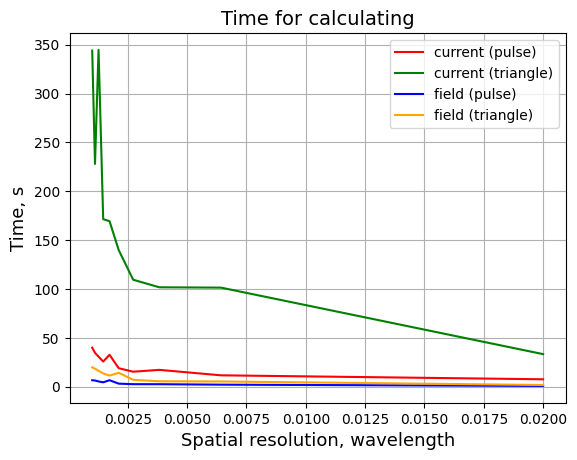

In [16]:
import matplotlib.pyplot as plt
plt.plot(dr / wavelength, time_cur_pulse, color = 'red', label = 'current (pulse)')
plt.plot(dr / wavelength, time_cur_triangle, color = 'green', label = 'current (triangle)')
plt.plot(dr / wavelength, time_e_pulse, color = 'blue', label = 'field (pulse)')
plt.plot(dr / wavelength, time_e_triangle, color = 'orange', label = 'field (triangle)')
plt.xlabel("Spatial resolution, wavelength", size = 13)
plt.ylabel("Time, s", size = 13)
plt.title("Time for calculating", size = 14)
#plt.yscale('log')
#plt.xscale('log')
plt.grid(True)
plt.legend()